# Project 1Bis. Kaggle Text to Emotion Dataset 1

### Dataset

https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text/data?select=tweet_emotions.csv

### Required Packages

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import nltk
import inflect
import contractions

from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [2]:
df = pd.read_csv('tweet_emotions.csv', delimiter=',')
df.head()

tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...

## Task 1. Exploratory Data Analysis

In [3]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))
    
    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))
    
    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))
    
    print("\nDescription of numerical variables")
    
    #### Describing numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))
    
    print("\nDescription of categorical variables")
    
    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))
    
    return

In [4]:
basic_eda(df)

Info : There are 3 columns in the dataset
Info : There are 40000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['sentiment', 'content']
Numerical columns :  ['tweet_id']


column_name   dtype
0    tweet_id   int64
1   sentiment  object
2     content  object


Description of numerical variables


column_name    count          mean           std           min  \
0    tweet_id  40000.0  1.845184e+09  1.188579e+08  1.693956e+09   

            25%           50%           75%           max  
0  1.751431e+09  1.855443e+09  1.962781e+09  1.966441e+09


Description of categorical variables


column_name  count unique  \
0   sentiment  40000     13   
1     content  40000  39827   

                                                 top  freq  
0                                            neutral  8638  
1  I just received a mothers day card from my lov...    14

In [5]:
# check for mising values
total_null = df.isnull().sum()
total_null

tweet_id     0
sentiment    0
content      0
dtype: int64

In [6]:
concatenated_string = ' '.join(df['content'])

words = concatenated_string.split()
print(len(words))

unique_words = set(words)
print(len(unique_words))


528675
83297


In [7]:
grouped_df = df.groupby('sentiment')['content'].apply(lambda x: ' '.join(x)).reset_index()

concatenated_tweets_df = pd.DataFrame({'sentiment': grouped_df['sentiment'], 'content': grouped_df['content']})
concatenated_tweets_df.head()

sentiment                                            content
0       anger  fuckin'm transtelecom Working   But it's Frida...
1     boredom  i'm so tired Waiting in line @ tryst why did i...
2       empty  @tiffanylue i know  i was listenin to bad habi...
3  enthusiasm  wants to hang out with friends SOON! bed...sor...
4         fun  Wondering why I'm awake at 7am,writing a new s...

In [8]:
concatenated_tweets_df['tokenized_content'] = concatenated_tweets_df['content'].apply(nltk.word_tokenize)
concatenated_tweets_df['unique_tokenized_content'] = concatenated_tweets_df['tokenized_content'].apply(set)

# Calculate the total tokenized words for each sentiment class
word_counts_by_sentiment = concatenated_tweets_df.groupby('sentiment')['tokenized_content'].apply(lambda x: sum(len(words) for words in x)).reset_index()
word_counts_by_sentiment.columns = ['sentiment', 'total_tokenized_words']

# Calculate the total unique tokenized words for each sentiment class
unique_word_counts_by_sentiment = concatenated_tweets_df.groupby('sentiment')['unique_tokenized_content'].apply(lambda x: sum(len(words) for words in x)).reset_index()
unique_word_counts_by_sentiment.columns = ['sentiment', 'total_unique_tokenized_words']

# Merge the two DataFrames to get both total and unique tokenized word counts
result_df = pd.merge(word_counts_by_sentiment, unique_word_counts_by_sentiment, on='sentiment')

print(result_df)

     sentiment  total_tokenized_words  total_unique_tokenized_words
0        anger                   1928                           864
1      boredom                   2966                          1156
2        empty                  11855                          3432
3   enthusiasm                  12731                          3431
4          fun                  32236                          6994
5    happiness                  87929                         13824
6         hate                  23459                          5269
7         love                  64416                         10249
8      neutral                 122124                         19902
9       relief                  25904                          5358
10     sadness                  87936                         12657
11    surprise                  37682                          7551
12       worry                 146548                         18528


### Creating Histogram

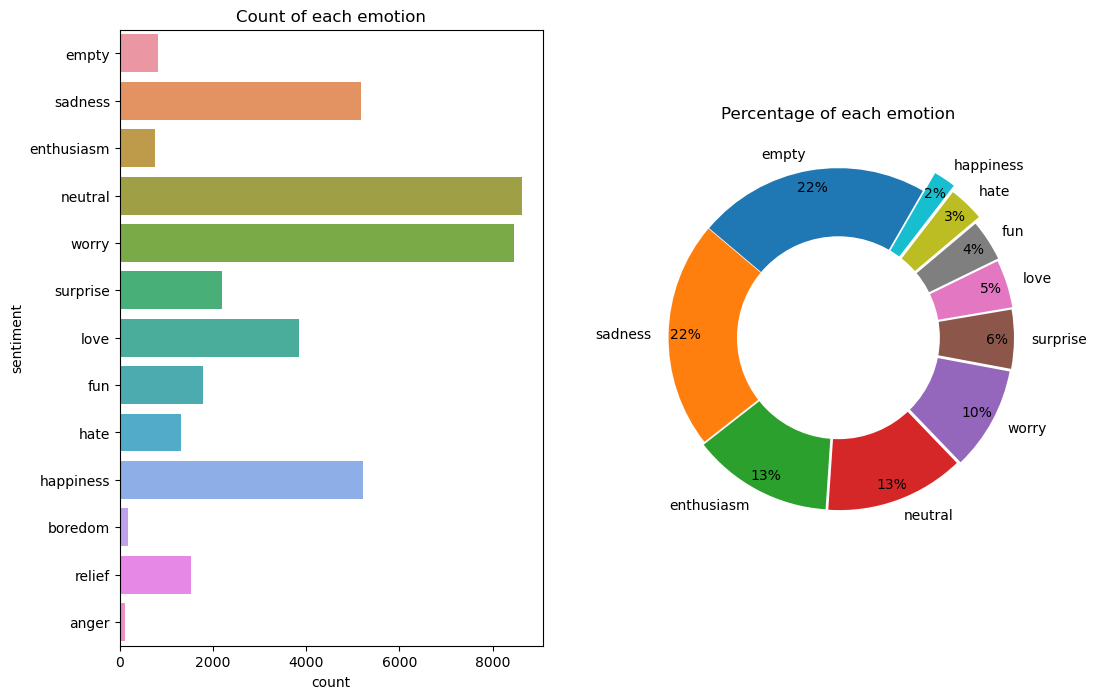

In [9]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]

ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

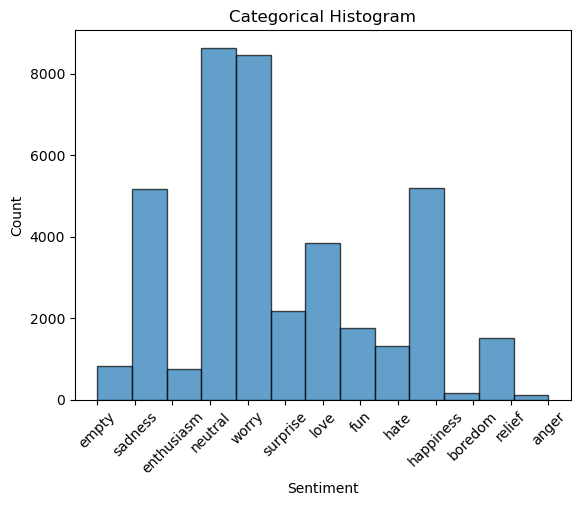

In [10]:
plt.hist(df.sentiment, bins=13, edgecolor='k', alpha=0.7)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Categorical Histogram')
plt.xticks(rotation=45)
plt.show()

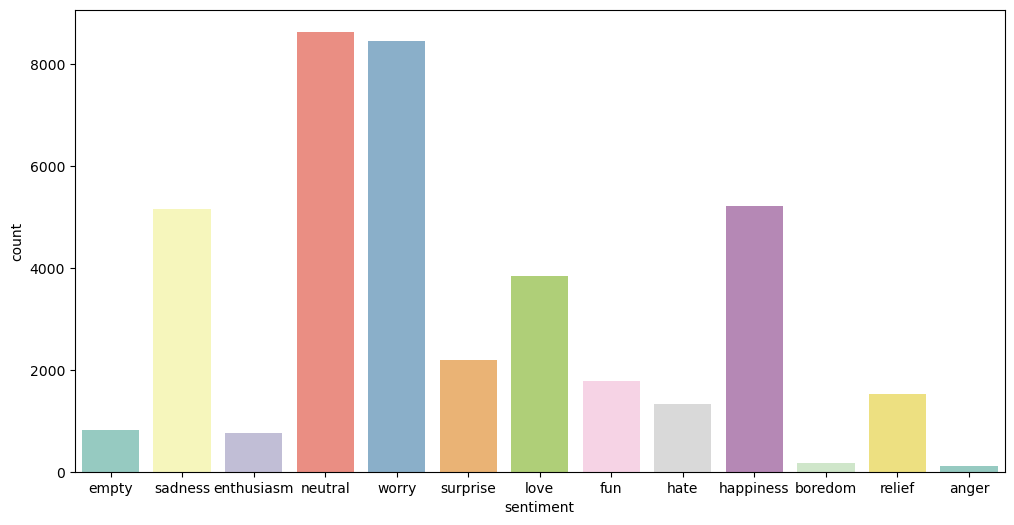

In [185]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="sentiment", palette='Set3')
plt.show()

#### Comment on the distribution of the training samples across various categories.

**Answer:**
    
There are 13 different categories and certain classes such as, Empty, Enthusiasm, Surprise, Fun, Hate, Boredom, Relief and Anger have very few examples compared to others, which can pose challanges while training machine learning models. So, it's important to consider the distribution of training samples across these categories. Here are some comments on this distribution,
    
1. **Class Imbalance:** The dataset is imbalanced as some classes have fewer training samples than others.
2. **Bias in Model Performance:** Imbalanced datasets can lead to model bias where the model may perform well on the majority classes but poorly on minority classes.

## Task 2 & 3. Finding the 10 most frequent keywords in each category, Drawing WordCloud before and after processing steps

### Concatenating all tweets of the same category

In [11]:
grouped_df = df.groupby('sentiment')['content'].apply(lambda x: ' '.join(x)).reset_index()

concatenated_tweets_df = pd.DataFrame({'sentiment': grouped_df['sentiment'], 'content': grouped_df['content']})

In [12]:
concatenated_tweets_df.to_csv('concatenated_tweets.csv', index=False)

### Text Preprocessing

In [13]:
def text_preprocessing(df, text_col, remove_stopwords=True):
    
    def denoise_text(text):
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    

    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        words = lemmatize_verbs(words)
        return words
    
    
    def tokenize(text):
        return nltk.word_tokenize(text)
    

    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    
    df[text_col] = [text_prepare(x) for x in df[text_col]]
    
    return df

### Univariate analysis and WordCloud of each category

to find out the most frequent keywords of each category of the 'sentiment' column in the corpus.

In [14]:
def print_word_cloud(df):
    sentiment_categories = df['sentiment'].unique()
    num_categories = len(sentiment_categories)

    # Create subplots
    fig, axes = plt.subplots(num_categories, 2, figsize=(14, 7*num_categories))
    
    for i, sentiment in enumerate(sentiment_categories):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        temp_df = df[df['sentiment'] == sentiment]
        corpus = ' '.join(temp_df['content'].astype(str))

        total = 0
        count = defaultdict(lambda: 0)
        for word in corpus.split():
            if word.strip():
                total += 1
                count[word] += 1

        top10pairs = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:10]
        top10words = [i[0] for i in top10pairs]
        top10freq = [i[1] for i in top10pairs]

        xs = np.arange(len(top10words))
        width = 0.5

        ax1.bar(xs, top10freq, width, align='center')
        ax1.set_title(f"Top 10 words frequency for sentiment: {sentiment}")
        ax1.set_xticks(xs)
        ax1.set_xticklabels(top10words, rotation=45)

        wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(corpus)
            
        ax2.imshow(wordcloud, interpolation="bilinear")
        ax2.set_title(f"Word cloud for sentiment: {sentiment}")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

Before Preprocessing:
@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[


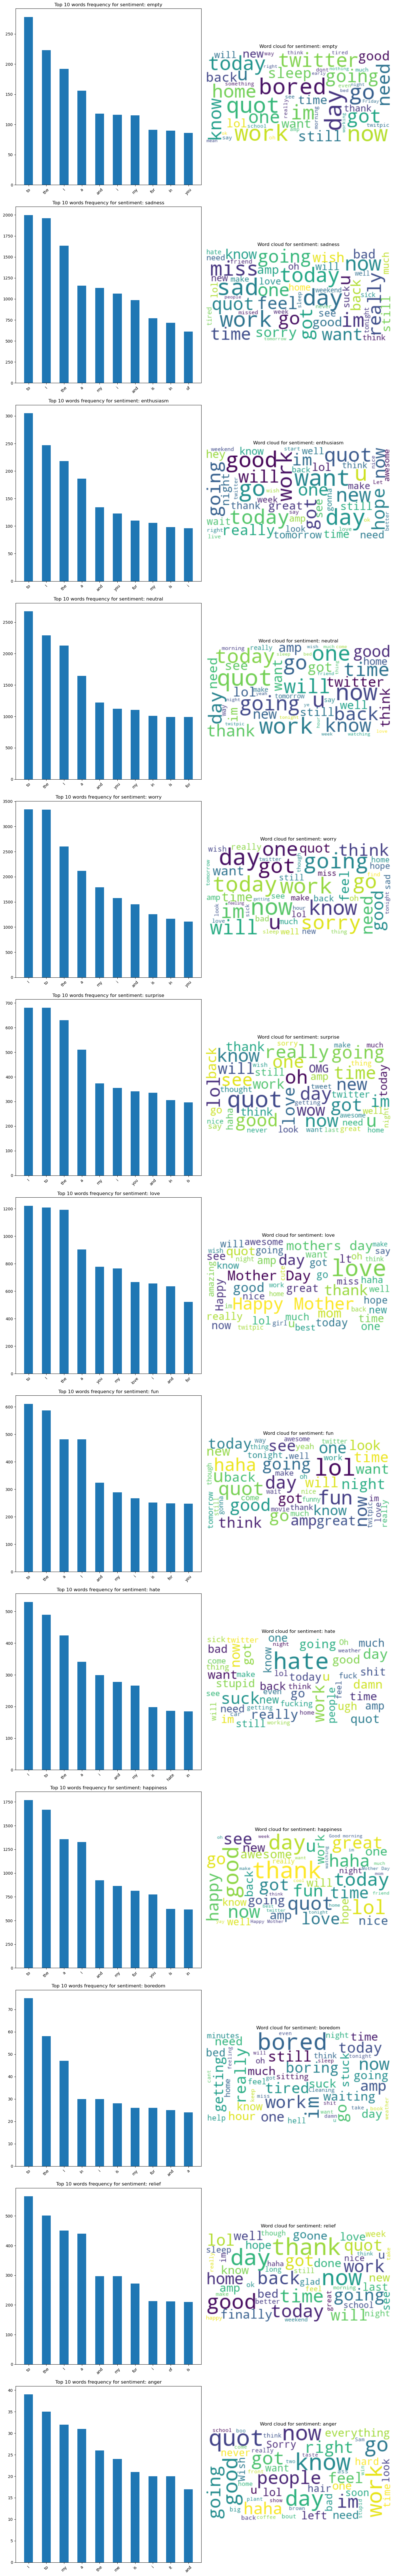

In [15]:
print('Before Preprocessing:')
print(df.content[0])
print_word_cloud(df)

tiffanylue know listenin bad habit earlier start freakin part


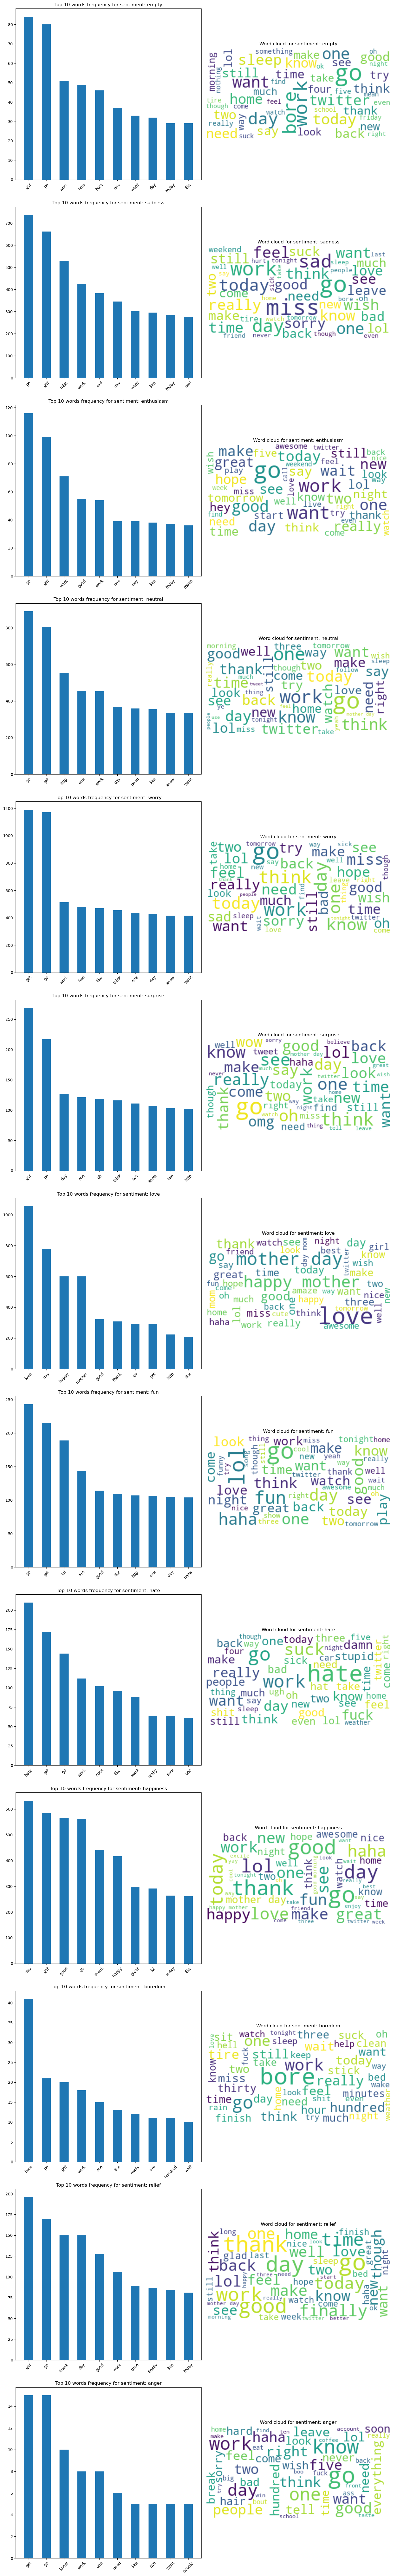

In [16]:
processed_df = text_preprocessing(df, 'content', remove_stopwords=True)
print(processed_df.content[0])
print_word_cloud(processed_df)

In [17]:
concatenated_string = ' '.join(processed_df['content'])

words = concatenated_string.split()
print(len(words))

unique_words = set(words)
print(len(unique_words))

301752
45489


In [18]:
processed_df['tokenized_content'] = processed_df['content'].apply(nltk.word_tokenize)
processed_df['unique_tokenized_content'] = processed_df['tokenized_content'].apply(set)

# Calculate the total tokenized words for each sentiment class
word_counts_by_sentiment = processed_df.groupby('sentiment')['tokenized_content'].apply(lambda x: sum(len(words) for words in x)).reset_index()
word_counts_by_sentiment.columns = ['sentiment', 'total_tokenized_words']

# Calculate the total unique tokenized words for each sentiment class
unique_word_counts_by_sentiment = processed_df.groupby('sentiment')['unique_tokenized_content'].apply(lambda x: sum(len(words) for words in x)).reset_index()
unique_word_counts_by_sentiment.columns = ['sentiment', 'total_unique_tokenized_words']

# Merge the two DataFrames to get both total and unique tokenized word counts
result_df = pd.merge(word_counts_by_sentiment, unique_word_counts_by_sentiment, on='sentiment')

print(result_df)

     sentiment  total_tokenized_words  total_unique_tokenized_words
0        anger                    854                           834
1      boredom                   1395                          1345
2        empty                   5485                          5327
3   enthusiasm                   5821                          5686
4          fun                  15044                         14643
5    happiness                  41510                         40393
6         hate                  10653                         10375
7         love                  29922                         28991
8      neutral                  57039                         55484
9       relief                  11995                         11711
10     sadness                  39639                         38636
11    surprise                  16769                         16332
12       worry                  65845                         64213


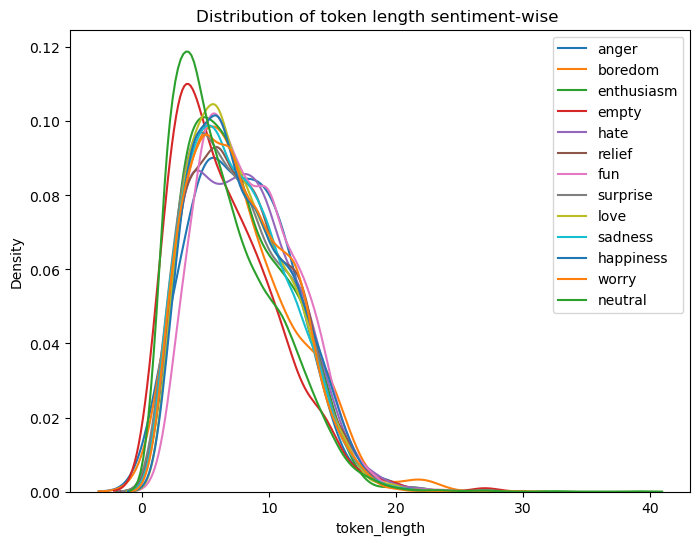

In [19]:
processed_df['token_length'] = processed_df['content'].apply(lambda x : len(x.split(" ")))

fig, ax = plt.subplots(figsize=(8,6))
for sentiment in processed_df['sentiment'].value_counts().sort_values().index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['sentiment']==sentiment]['token_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of token length sentiment-wise ")
plt.show()

## Task 4. Construction A -> Manually reducing the categories from 13 to 3 (Positive, Negative and Neutral)

In [20]:
category_mapping_A = {
    'empty': 'Neutral',
    'sadness': 'Negative',
    'enthusiasm': 'Positive',
    'neutral': 'Neutral',
    'worry': 'Negative',
    'surprise': 'Positive',
    'love': 'Positive',
    'fun': 'Positive',
    'hate': 'Negative',
    'happiness': 'Positive',
    'boredom': 'Negative',
    'relief': 'Positive',
    'anger': 'Negative'
}

In [21]:
# Map the 'sentiment' column using category_mapping_A
processed_df['manual_sentiment'] = processed_df['sentiment'].map(category_mapping_A)

# Display the constructed DataFrame
processed_df.head()

tweet_id   sentiment                                            content  \
0  1956967341       empty  tiffanylue know listenin bad habit earlier sta...   
1  1956967666     sadness            layin n bed headache ughhhh waitin call   
2  1956967696     sadness                     funeral ceremony gloomy friday   
3  1956967789  enthusiasm                             want hang friends soon   
4  1956968416     neutral  dannycastillo want trade someone houston ticke...   

                                   tokenized_content  \
0  [tiffanylue, know, listenin, bad, habit, earli...   
1    [layin, n, bed, headache, ughhhh, waitin, call]   
2                [funeral, ceremony, gloomy, friday]   
3                        [want, hang, friends, soon]   
4  [dannycastillo, want, trade, someone, houston,...   

                            unique_tokenized_content  token_length  \
0  {freakin, know, bad, earlier, part, tiffanylue...             9   
1    {layin, n, bed, waitin, call, headache, ughhhh}             7   
2                {friday, funeral, ceremony, gloomy}             4   
3                        {soon, hang, friends, want}             4   
4  {ticket, dannycastillo, trade, one, someone, w...             7   

  manual_sentiment  
0          Neutral  
1         Negative  
2         Negative  
3         Positive  
4          Neutral

## Task 5. Construction B -> Reducing into 3 categories using Word2Vec and k-means

In [22]:
from gensim.models import Word2Vec

category_titles = processed_df['sentiment'].unique()
category_title_tokens = [title.split() for title in category_titles]

# Train a Word2Vec model
model = Word2Vec(category_title_tokens, vector_size=100, window=5, min_count=1, sg=1)

# Get the Word2Vec embeddings for each category title
category_embeddings = {category: model.wv[category] for category in category_titles}

In [23]:
from sklearn.cluster import KMeans

# Convert the Word2Vec embeddings to a list
embedding_vectors = [category_embeddings[category] for category in category_titles]

# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=0).fit(embedding_vectors)

# Get the cluster labels for each category title
cluster_labels = kmeans.labels_

In [24]:
cluster_labels

array([0, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 0], dtype=int32)

In [25]:
# Map cluster labels to constructed categories
constructed_categories = ['Neutral', 'Negative', 'Positive']
mapped_constructed_categories = [constructed_categories[label] for label in cluster_labels]

processed_df['Word2Vec_sentiment'] = processed_df['sentiment'].map({category_titles[i]: mapped_constructed_categories[i] for i in range(len(category_titles))})
processed_df.head(5)

tweet_id   sentiment                                            content  \
0  1956967341       empty  tiffanylue know listenin bad habit earlier sta...   
1  1956967666     sadness            layin n bed headache ughhhh waitin call   
2  1956967696     sadness                     funeral ceremony gloomy friday   
3  1956967789  enthusiasm                             want hang friends soon   
4  1956968416     neutral  dannycastillo want trade someone houston ticke...   

                                   tokenized_content  \
0  [tiffanylue, know, listenin, bad, habit, earli...   
1    [layin, n, bed, headache, ughhhh, waitin, call]   
2                [funeral, ceremony, gloomy, friday]   
3                        [want, hang, friends, soon]   
4  [dannycastillo, want, trade, someone, houston,...   

                            unique_tokenized_content  token_length  \
0  {freakin, know, bad, earlier, part, tiffanylue...             9   
1    {layin, n, bed, waitin, call, headache, ughhhh}             7   
2                {friday, funeral, ceremony, gloomy}             4   
3                        {soon, hang, friends, want}             4   
4  {ticket, dannycastillo, trade, one, someone, w...             7   

  manual_sentiment Word2Vec_sentiment  
0          Neutral            Neutral  
1         Negative           Negative  
2         Negative           Negative  
3         Positive            Neutral  
4          Neutral            Neutral

In [26]:
# processed_df['tokenized_content'] = processed_df['content'].apply(nltk.word_tokenize)
# processed_df['unique_tokenized_content'] = processed_df['tokenized_content'].apply(set)

# Calculate the total tokenized words for each sentiment class
word_counts_by_sentiment = processed_df.groupby('Word2Vec_sentiment')['tokenized_content'].apply(lambda x: sum(len(words) for words in x)).reset_index()
word_counts_by_sentiment.columns = ['Word2Vec_sentiment', 'total_tokenized_words']

# Calculate the total unique tokenized words for each sentiment class
unique_word_counts_by_sentiment = processed_df.groupby('Word2Vec_sentiment')['unique_tokenized_content'].apply(lambda x: sum(len(words) for words in x)).reset_index()
unique_word_counts_by_sentiment.columns = ['Word2Vec_sentiment', 'total_unique_tokenized_words']

# Merge the two DataFrames to get both total and unique tokenized word counts
result_df = pd.merge(word_counts_by_sentiment, unique_word_counts_by_sentiment, on='Word2Vec_sentiment')

print(result_df)

  Word2Vec_sentiment  total_tokenized_words  total_unique_tokenized_words
0           Negative                 147454                        143560
1            Neutral                  85968                         83663
2           Positive                  68549                         66747


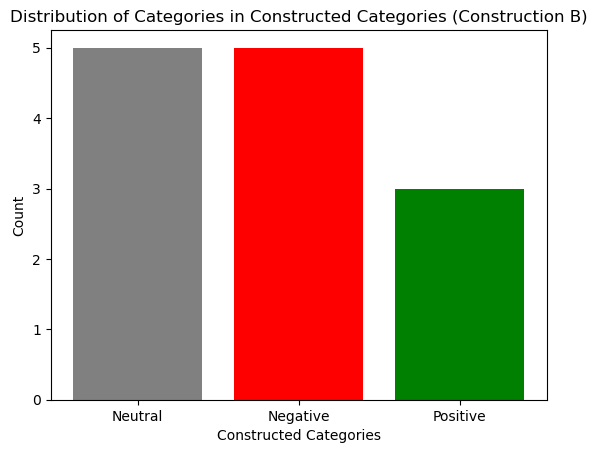

In [27]:
# Count the number of categories in each constructed category
category_counts = {constructed_category: mapped_constructed_categories.count(constructed_category) for constructed_category in constructed_categories}

# Create a bar chart to visualize the distribution of categories in constructed categories
plt.bar(category_counts.keys(), category_counts.values(), color=['gray', 'red', 'green'])
plt.xlabel("Constructed Categories")
plt.ylabel("Count")
plt.title("Distribution of Categories in Constructed Categories (Construction B)")
plt.show()

## Task 6. Comparison between Constuction A and B

**Computing the overlap of words (number of common tokens) for the processed dataframe**

In [28]:
manual_df = processed_df.groupby('manual_sentiment')['content'].apply(lambda x: ' '.join(x)).reset_index()

manual_tweets_df = pd.DataFrame({'manual_sentiment': manual_df['manual_sentiment'], 'content': manual_df['content']})

In [29]:
manual_tweets_df

manual_sentiment                                            content
0         Negative  layin n bed headache ughhhh waitin call funera...
1          Neutral  tiffanylue know listenin bad habit earlier sta...
2         Positive  want hang friends soon get news annarosekerr a...

In [30]:
word2vec_df = processed_df.groupby('Word2Vec_sentiment')['content'].apply(lambda x: ' '.join(x)).reset_index()

word2vec_tweets_df = pd.DataFrame({'Word2Vec_sentiment': word2vec_df['Word2Vec_sentiment'], 'content': word2vec_df['content']})

In [31]:
word2vec_tweets_df

Word2Vec_sentiment                                            content
0           Negative  layin n bed headache ughhhh waitin call funera...
1            Neutral  tiffanylue know listenin bad habit earlier sta...
2           Positive  wonder awake 7am write new song plot evil secr...

**Summary of the number of common tokens for each class in Construction A and B.**

In [32]:
def calculate_common_tokens(df1, df2):
    # Extract content for each category from the first dataframe (df1)
    positive_df1 = df1[df1['manual_sentiment'] == 'Positive']['content'].iloc[0]
    negative_df1 = df1[df1['manual_sentiment'] == 'Negative']['content'].iloc[0]
    neutral_df1 = df1[df1['manual_sentiment'] == 'Neutral']['content'].iloc[0]

    # Extract content for each category from the second dataframe (df2)
    positive_df2 = df2[df2['Word2Vec_sentiment'] == 'Positive']['content'].iloc[0]
    negative_df2 = df2[df2['Word2Vec_sentiment'] == 'Negative']['content'].iloc[0]
    neutral_df2 = df2[df2['Word2Vec_sentiment'] == 'Neutral']['content'].iloc[0]

    # Tokenize the content and find the common tokens for each category
    tokens_positive_df1 = set(positive_df1.split())
    tokens_negative_df1 = set(negative_df1.split())
    tokens_neutral_df1 = set(neutral_df1.split())

    tokens_positive_df2 = set(positive_df2.split())
    tokens_negative_df2 = set(negative_df2.split())
    tokens_neutral_df2 = set(neutral_df2.split())

    # Compute the number of common tokens for each category
    common_tokens_positive = len(tokens_positive_df1.intersection(tokens_positive_df2))
    common_tokens_negative = len(tokens_negative_df1.intersection(tokens_negative_df2))
    common_tokens_neutral = len(tokens_neutral_df1.intersection(tokens_neutral_df2))

    return {
        'Positive': common_tokens_positive,
        'Negative': common_tokens_negative,
        'Neutral': common_tokens_neutral
    }

# Calculate word overlap
common_tokens = calculate_common_tokens(manual_tweets_df, word2vec_tweets_df)

print(f"Number of Common Words:")
for category, common_count in common_tokens.items():
    print(f"{category}:", common_count)

Number of Common Words:
Positive: 15096
Negative: 20894
Neutral: 16395


## Task 7. Most Frequent Wording in Each Dataframe

In [33]:
# def calculate_common_tokens_most_frequent(df1, df2, n_most_frequent):
#     # Create dictionaries to store the n_most_frequent tokens for each category
#     tokens_df1 = {'Positive': set(), 'Negative': set(), 'Neutral': set()}
#     tokens_df2 = {'Positive': set(), 'Negative': set(), 'Neutral': set()}

#     # Iterate through the data frames and tokenize content
#     for index, row in df1.iterrows():
#         sentiment = row['manual_sentiment']
#         tokens = row['content'].split()
#         frequent_tokens = set(tokens[:n_most_frequent])
#         tokens_df1[sentiment].update(frequent_tokens)

#     for index, row in df2.iterrows():
#         sentiment = row['Word2Vec_sentiment']
#         tokens = row['content'].split()
#         frequent_tokens = set(tokens[:n_most_frequent])
#         tokens_df2[sentiment].update(frequent_tokens)

#     # Calculate the total number of common tokens for each class
#     common_tokens = {'Positive': 0, 'Negative': 0, 'Neutral': 0}

#     for sentiment in common_tokens.keys():
#         common_tokens[sentiment] = len(tokens_df1[sentiment].intersection(tokens_df2[sentiment]))

#     return common_tokens

# # Call the function to calculate common tokens with the most frequent words
# common_tokens_most_frequent = calculate_common_tokens_most_frequent(manual_tweets_df, word2vec_tweets_df, 20)

# print(f"Most Frequent Words:")
# for category, common_count in common_tokens_most_frequent.items():
#     print(f"{category}:", common_count)


In [34]:
def manual_word_cloud(df):
    sentiment_categories = df['manual_sentiment'].unique()
    num_categories = len(sentiment_categories)

    # Create subplots
    fig, axes = plt.subplots(num_categories, 2, figsize=(14, 7*num_categories))
    
    for i, sentiment in enumerate(sentiment_categories):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        temp_df = df[df['manual_sentiment'] == sentiment]
        corpus = ' '.join(temp_df['content'].astype(str))

        total = 0
        count = defaultdict(lambda: 0)
        for word in corpus.split():
            if word.strip():
                total += 1
                count[word] += 1

        top20pairs = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:20]
        top20words = [i[0] for i in top20pairs]
        top20freq = [i[1] for i in top20pairs]

        xs = np.arange(len(top20words))
        width = 0.5

        ax1.bar(xs, top20freq, width, align='center')
        ax1.set_title(f"Top 20 words frequency for sentiment: {sentiment}")
        ax1.set_xticks(xs)
        ax1.set_xticklabels(top20words, rotation=45)

        wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(corpus)
            
        ax2.imshow(wordcloud, interpolation="bilinear")
        ax2.set_title(f"Word cloud for sentiment: {sentiment}")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

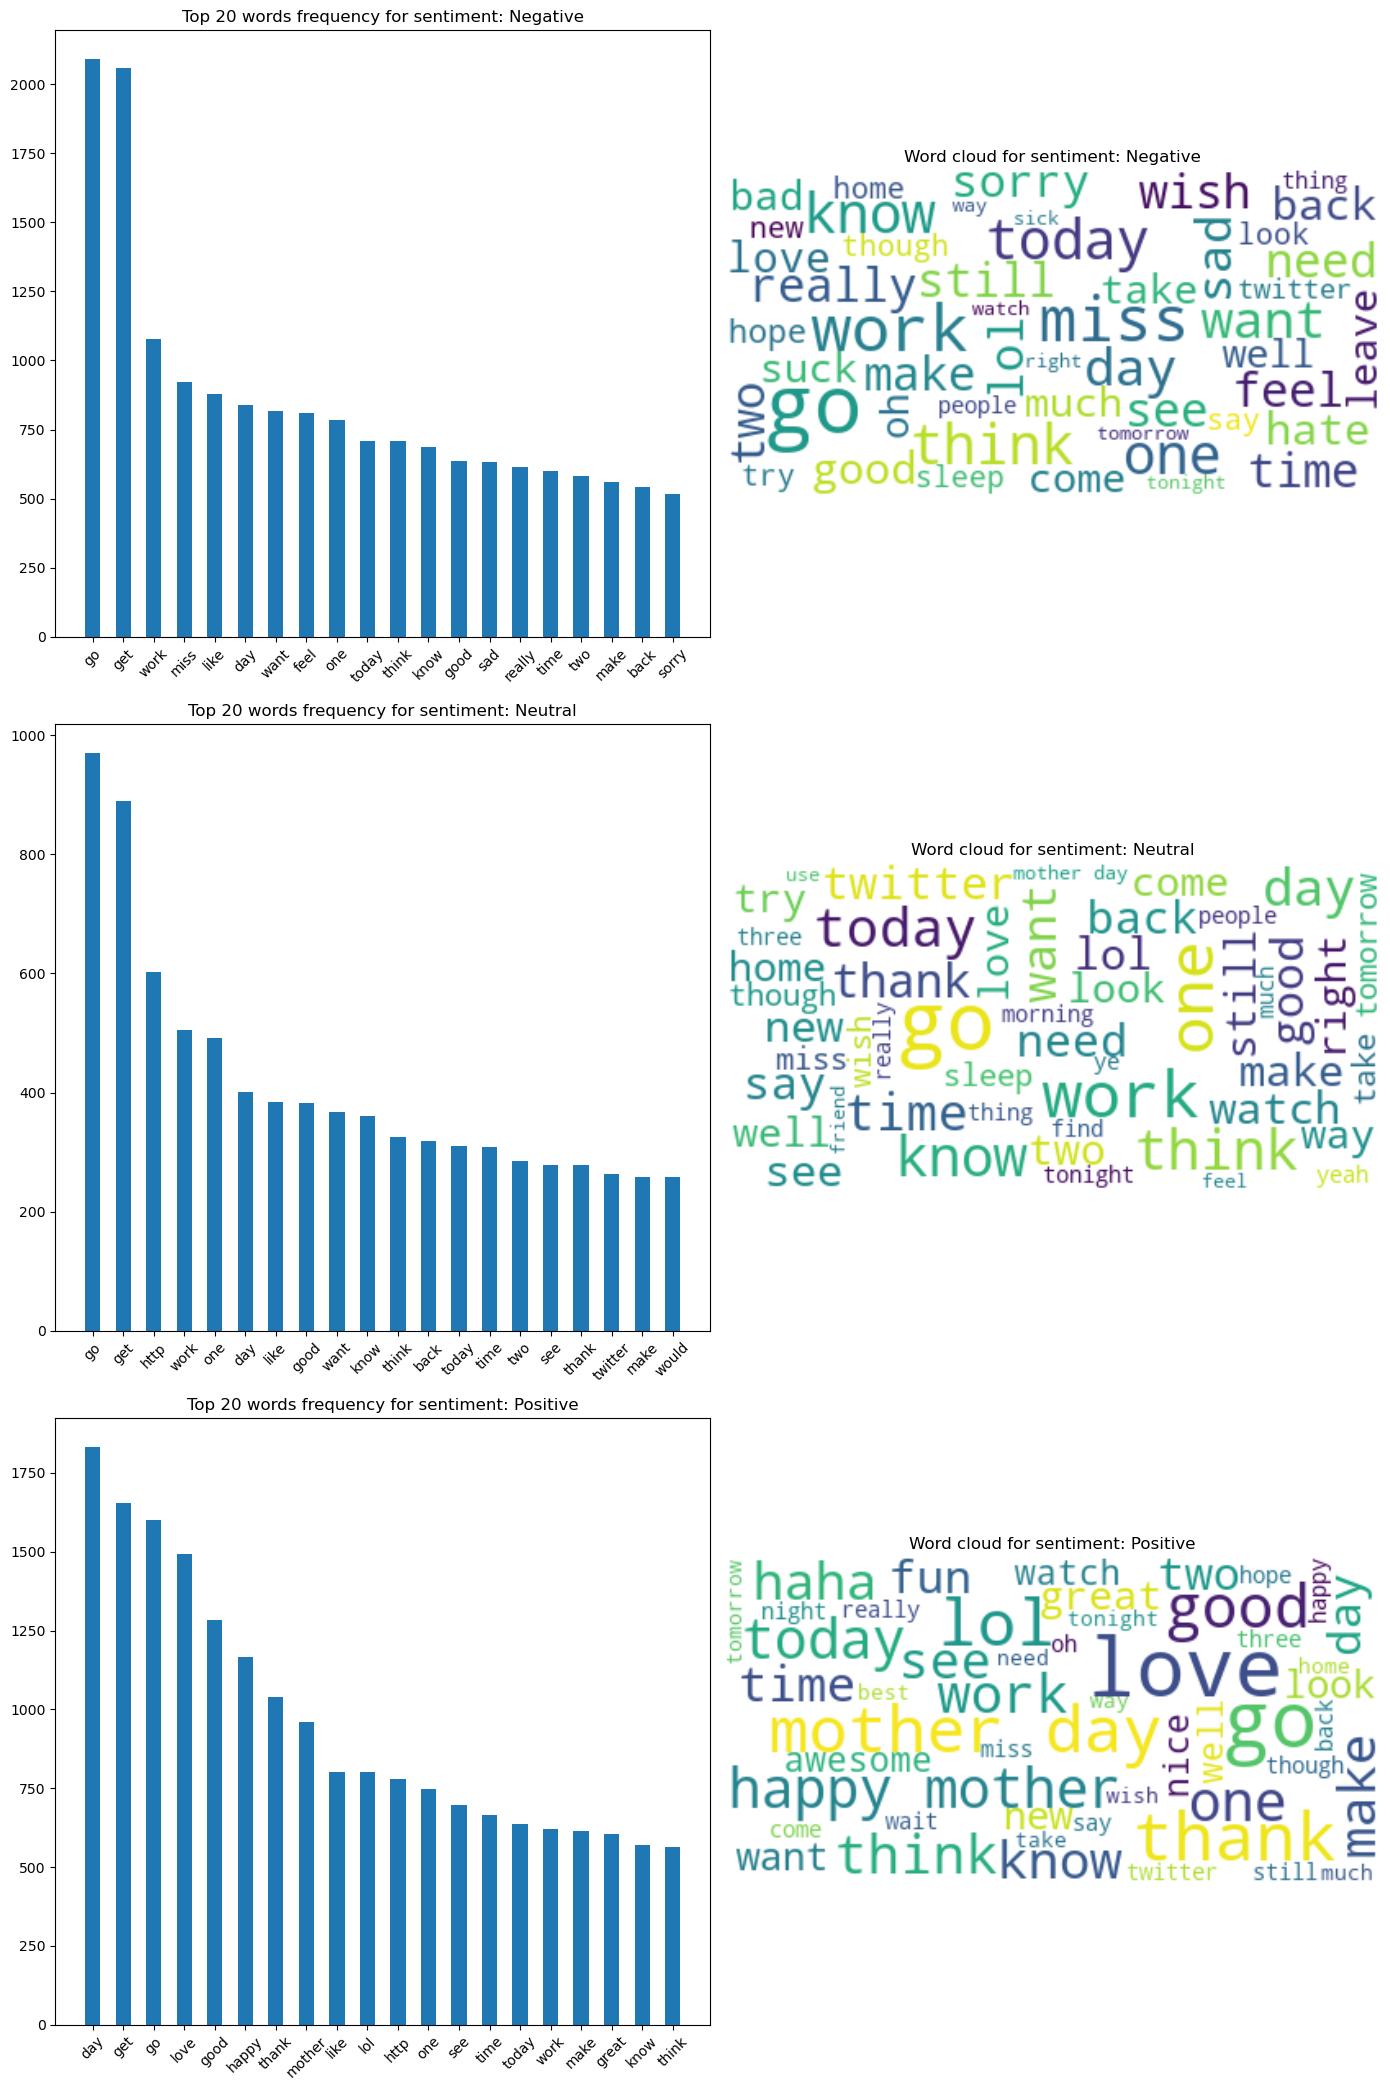

In [35]:
manual_word_cloud(manual_df)

In [36]:
def word2vec_word_cloud(df):
    sentiment_categories = df['Word2Vec_sentiment'].unique()
    num_categories = len(sentiment_categories)

    # Create subplots
    fig, axes = plt.subplots(num_categories, 2, figsize=(14, 7*num_categories))
    
    for i, sentiment in enumerate(sentiment_categories):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        temp_df = df[df['Word2Vec_sentiment'] == sentiment]
        corpus = ' '.join(temp_df['content'].astype(str))

        total = 0
        count = defaultdict(lambda: 0)
        for word in corpus.split():
            if word.strip():
                total += 1
                count[word] += 1

        top20pairs = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:20]
        top20words = [i[0] for i in top20pairs]
        top20freq = [i[1] for i in top20pairs]

        xs = np.arange(len(top20words))
        width = 0.5

        ax1.bar(xs, top20freq, width, align='center')
        ax1.set_title(f"Top 20 words frequency for sentiment: {sentiment}")
        ax1.set_xticks(xs)
        ax1.set_xticklabels(top20words, rotation=45)

        wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(corpus)
            
        ax2.imshow(wordcloud, interpolation="bilinear")
        ax2.set_title(f"Word cloud for sentiment: {sentiment}")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

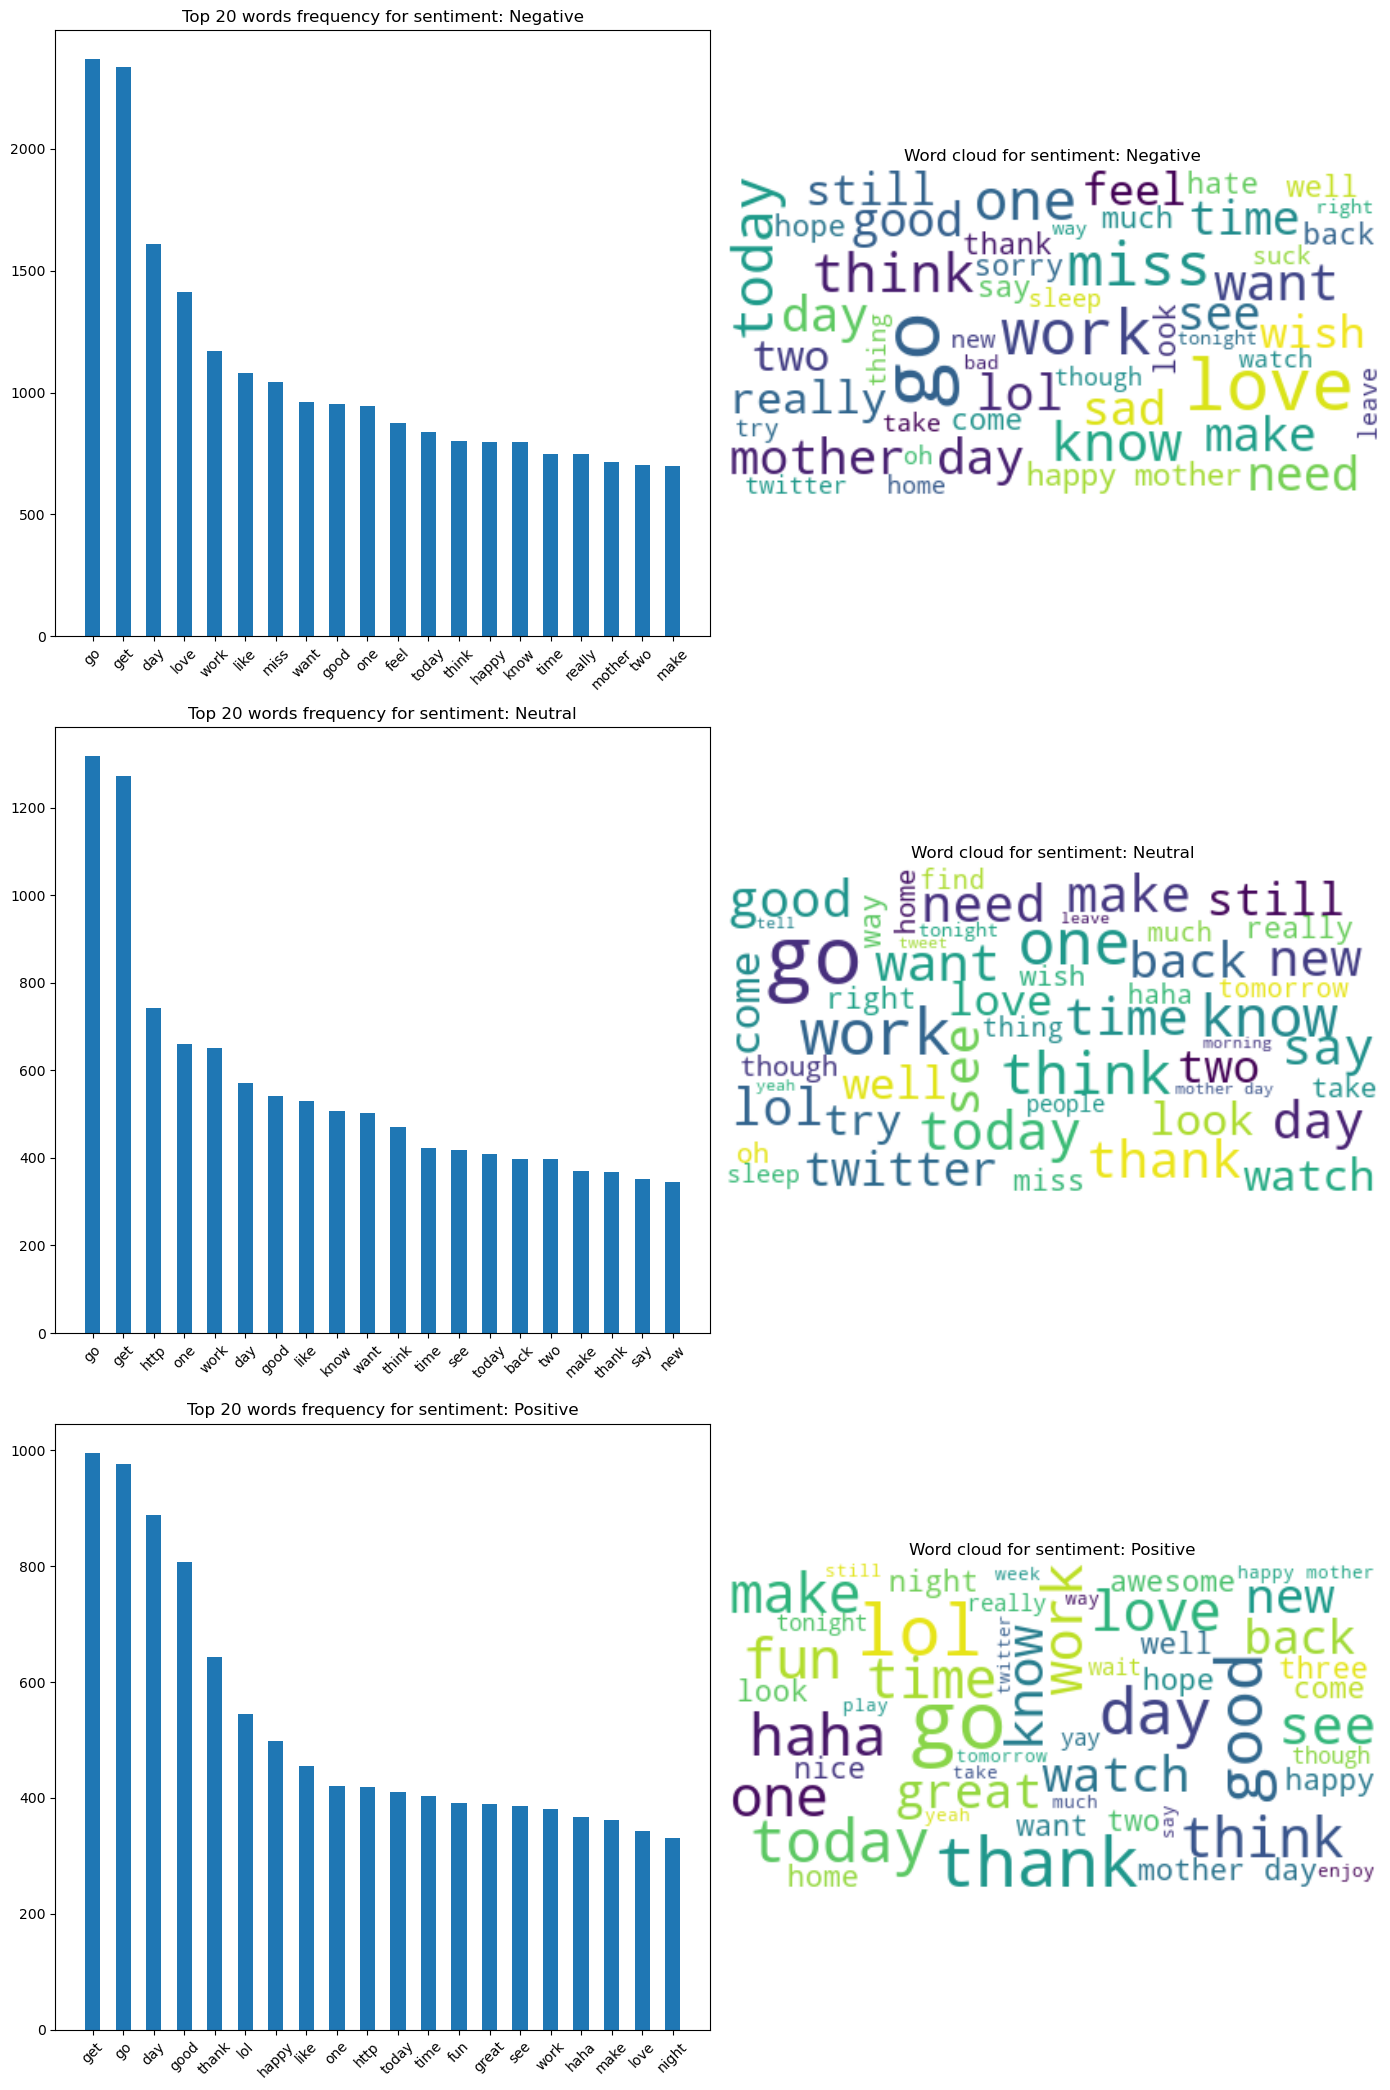

In [37]:
word2vec_word_cloud(word2vec_df)

In [38]:
# Define a function to extract the top N most frequent words for each category
def extract_top_words(df, category_column, content_column, n=20):
    top_words = {}
    sentiment_categories = df[category_column].unique()
    
    for sentiment in sentiment_categories:
        temp_df = df[df[category_column] == sentiment]
        corpus = ' '.join(temp_df[content_column].astype(str))

        total = 0
        count = defaultdict(lambda: 0)
        for word in corpus.split():
            if word.strip():
                total += 1
                count[word] += 1

        top_pairs = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:n]
        top_words[sentiment] = [i[0] for i in top_pairs]

    return top_words

# Extract the top 20 most frequent words for each category from manual_df
top_words_manual = extract_top_words(manual_df, 'manual_sentiment', 'content')

# Extract the top 20 most frequent words for each category from word2vec_df
top_words_word2vec = extract_top_words(word2vec_df, 'Word2Vec_sentiment', 'content')

# Print the top words for each category in both dataframes
print("Top words in manual_df:")
for sentiment, words in top_words_manual.items():
    print(f"{sentiment}:", words)

print("\nTop words in word2vec_df:")
for sentiment, words in top_words_word2vec.items():
    print(f"{sentiment}:", words)


Top words in manual_df:
Negative: ['go', 'get', 'work', 'miss', 'like', 'day', 'want', 'feel', 'one', 'today', 'think', 'know', 'good', 'sad', 'really', 'time', 'two', 'make', 'back', 'sorry']
Neutral: ['go', 'get', 'http', 'work', 'one', 'day', 'like', 'good', 'want', 'know', 'think', 'back', 'today', 'time', 'two', 'see', 'thank', 'twitter', 'make', 'would']
Positive: ['day', 'get', 'go', 'love', 'good', 'happy', 'thank', 'mother', 'like', 'lol', 'http', 'one', 'see', 'time', 'today', 'work', 'make', 'great', 'know', 'think']

Top words in word2vec_df:
Negative: ['go', 'get', 'day', 'love', 'work', 'like', 'miss', 'want', 'good', 'one', 'feel', 'today', 'think', 'happy', 'know', 'time', 'really', 'mother', 'two', 'make']
Neutral: ['go', 'get', 'http', 'one', 'work', 'day', 'good', 'like', 'know', 'want', 'think', 'time', 'see', 'today', 'back', 'two', 'make', 'thank', 'say', 'new']
Positive: ['get', 'go', 'day', 'good', 'thank', 'lol', 'happy', 'like', 'one', 'http', 'today', 'time',

In [39]:
# Compare the top words for each class in both dataframes
common_frequent_words = {}
for sentiment in manual_df['manual_sentiment'].unique():
    manual_words = set(top_words_manual[sentiment])
    word2vec_words = set(top_words_word2vec[sentiment])
    common_words = manual_words.intersection(word2vec_words)
    common_frequent_words[sentiment] = common_words

# Print the common frequent words for each class
for sentiment, common_words in common_frequent_words.items():
    print(f"Common frequent words in {sentiment} class:", common_words)


Common frequent words in Negative class: {'feel', 'get', 'day', 'go', 'miss', 'good', 'think', 'really', 'know', 'one', 'today', 'time', 'like', 'want', 'work', 'make', 'two'}
Common frequent words in Neutral class: {'get', 'day', 'go', 'think', 'good', 'http', 'know', 'one', 'today', 'thank', 'time', 'see', 'like', 'want', 'work', 'make', 'two', 'back'}
Common frequent words in Positive class: {'get', 'day', 'go', 'good', 'http', 'lol', 'happy', 'great', 'one', 'today', 'thank', 'time', 'love', 'see', 'like', 'work', 'make'}


In [40]:
def calculate_common_frequent_words(top_words1, top_words2):
    common_frequent_words = {}

    for sentiment in top_words1:
        words_set1 = set(top_words1[sentiment])
        words_set2 = set(top_words2[sentiment])
        common_words = words_set1.intersection(words_set2)
        common_frequent_words[sentiment] = len(common_words)

    return common_frequent_words

# Calculate the number of common frequent words for each class
common_frequent_words = calculate_common_frequent_words(top_words_manual, top_words_word2vec)

# Print the results
for sentiment, common_count in common_frequent_words.items():
    print(f"{sentiment}:", common_count)

Negative: 17
Neutral: 18
Positive: 17


In [41]:
# Calculate the number of common frequent words for each class using Jaccard Similarity
from sklearn.metrics import jaccard_score

def calculate_jaccard_similarity(top_words1, top_words2):
    jaccard_similarities = {}

    for sentiment in top_words1:
        words_set1 = set(top_words1[sentiment])
        words_set2 = set(top_words2[sentiment])
        jaccard_similarity = len(words_set1.intersection(words_set2)) / len(words_set1.union(words_set2))
        jaccard_similarities[sentiment] = jaccard_similarity

    return jaccard_similarities

# Calculate Jaccard similarity for each sentiment class
jaccard_similarities = calculate_jaccard_similarity(top_words_manual, top_words_word2vec)

# Print the results
for sentiment, similarity in jaccard_similarities.items():
    print(f"Jaccard similarity for {sentiment} class:", similarity)


Jaccard similarity for Negative class: 0.7391304347826086
Jaccard similarity for Neutral class: 0.8181818181818182
Jaccard similarity for Positive class: 0.7391304347826086


## Task 8. Unmatched Tokens

In [154]:
import nltk
from nltk.corpus import wordnet
import pandas as pd

In [155]:
# Function to check if a word exists in WordNet
def is_word_in_wordnet(word):
    synsets = wordnet.synsets(word)
    return len(synsets) > 0

In [156]:
# Function to process text and return the number of unmatched tokens and unmatched percentage
def process_text(text):
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    unmatched_tokens = [token for token in tokens if not is_word_in_wordnet(token)]
    unmatched_percentage = len(unmatched_tokens) / len(tokens) * 100 if tokens else 0
    return len(unmatched_tokens), unmatched_percentage

In [157]:
# Creating a summary table for manual class
manual_df = processed_df.groupby('manual_sentiment')['content'].apply(lambda x: ' '.join(x)).reset_index()
manual_tweets_df = pd.DataFrame({'manual_sentiment': manual_df['manual_sentiment'], 'content': manual_df['content']})

summary_data = []

for index, row in manual_tweets_df.iterrows():
    text = row['content']
    unmatched_tokens, unmatched_percentage = process_text(text)
    category = row['manual_sentiment']
    summary_data.append({'Category': category, 'Unmatched Tokens': unmatched_tokens, 'Unmatched Percentage': unmatched_percentage})

summary_table = pd.DataFrame(summary_data)

# Display the summary table
print("Summary Table for Manual Sentiment:")
print(summary_table)

Summary Table for Manual Sentiment:
   Category  Unmatched Tokens  Unmatched Percentage
0  Negative             22071             18.643252
1   Neutral             14942             23.898023
2  Positive             26130             21.584160


In [158]:
# Creating a summary table for word2vec class
word2vec_df = processed_df.groupby('Word2Vec_sentiment')['content'].apply(lambda x: ' '.join(x)).reset_index()
word2vec_tweets_df = pd.DataFrame({'Word2Vec_sentiment': word2vec_df['Word2Vec_sentiment'], 'content': word2vec_df['content']})

summary_data = []

for index, row in word2vec_tweets_df.iterrows():
    text = row['content']
    unmatched_tokens, unmatched_percentage = process_text(text)
    category = row['Word2Vec_sentiment']
    summary_data.append({'Category': category, 'Unmatched Tokens': unmatched_tokens, 'Unmatched Percentage': unmatched_percentage})

summary_table = pd.DataFrame(summary_data)

# Display the summary table
print("Summary Table for Word2vec Sentiment:")
print(summary_table)

Summary Table for Word2vec Sentiment:
   Category  Unmatched Tokens  Unmatched Percentage
0  Negative             28295             19.189035
1   Neutral             20067             23.342406
2  Positive             14781             21.562678


## Task 9. Mapping on NRC Lexicon & Data Frames

In [42]:
nrc_lexicon = pd.read_csv('nrc.csv')
nrc_lexicon.head()

word sentiment
0     abacus     trust
1    abandon      fear
2    abandon  negative
3    abandon   sadness
4  abandoned     anger

In [44]:
nrc_categories = nrc_lexicon['sentiment'].unique().tolist()

### for Original Dataset:

In [93]:
# Create a dictionary to store NRC category counts for each record
nrc_category_counts = {category: [] for category in nrc_categories}

# Create a dictionary to store labeling information for each record
labeling_info = {category: [] for category in nrc_categories}

# Iterate through the dataset and calculate NRC category counts and labeling information
for idx, row in processed_df.iterrows():
    content = row['content']
    sentiment = row['sentiment']

    # Tokenize the tweet content
    tokens = content.split()

    # Initialize the NRC category counts for this tweet
    record_category_counts = {category: 0 for category in nrc_categories}

    # Update NRC category counts
    for token in tokens:
        matching_rows = nrc_lexicon[nrc_lexicon['word'] == token]
        for category in nrc_categories:
            if category in matching_rows['sentiment'].values:
                record_category_counts[category] += 1

    # Update the NRC category counts dictionary for this tweet
    for category in nrc_categories:
        nrc_category_counts[category].append(record_category_counts[category])

    # Update labeling information for this tweet
    for category in nrc_categories:
        if category == sentiment:
            labeling_info[category].append(1)
        else:
            labeling_info[category].append(0)

# Create DataFrames from the NRC category counts and labeling information
nrc_vector_df = pd.DataFrame(nrc_category_counts)
nrc_vector_df['tweet_id'] = processed_df['tweet_id']
nrc_vector_df['content'] = processed_df['content']
nrc_vector_df['sentiment'] = processed_df['sentiment']

labeling_vector_df = pd.DataFrame(labeling_info)
labeling_vector_df['tweet_id'] = processed_df['tweet_id']
labeling_vector_df['content'] = processed_df['content']
labeling_vector_df['sentiment'] = processed_df['sentiment']

# Save the DataFrames as CSV files or use them for further analysis
nrc_vector_df.to_csv('twitter_nrc_entity.csv', index=False)
labeling_vector_df.to_csv('twitter_nrc_labeling_vector.csv', index=False)

In [94]:
nrc_vector_df.head()

trust  fear  negative  sadness  anger  surprise  positive  disgust  joy  \
0      0     1         1        1      1         0         0        1    0   
1      0     0         1        0      0         0         0        0    0   
2      0     0         1        2      0         1         1        0    1   
3      0     0         0        0      0         0         0        0    0   
4      1     0         0        0      0         0         0        0    0   

   anticipation    tweet_id  \
0             1  1956967341   
1             0  1956967666   
2             0  1956967696   
3             0  1956967789   
4             0  1956968416   

                                             content   sentiment  
0  tiffanylue know listenin bad habit earlier sta...       empty  
1            layin n bed headache ughhhh waitin call     sadness  
2                     funeral ceremony gloomy friday     sadness  
3                             want hang friends soon  enthusiasm  
4  dannycastillo want trade someone houston ticke...     neutral

In [95]:
labeling_vector_df.head()

trust  fear  negative  sadness  anger  surprise  positive  disgust  joy  \
0      0     0         0        0      0         0         0        0    0   
1      0     0         0        1      0         0         0        0    0   
2      0     0         0        1      0         0         0        0    0   
3      0     0         0        0      0         0         0        0    0   
4      0     0         0        0      0         0         0        0    0   

   anticipation    tweet_id  \
0             0  1956967341   
1             0  1956967666   
2             0  1956967696   
3             0  1956967789   
4             0  1956968416   

                                             content   sentiment  
0  tiffanylue know listenin bad habit earlier sta...       empty  
1            layin n bed headache ughhhh waitin call     sadness  
2                     funeral ceremony gloomy friday     sadness  
3                             want hang friends soon  enthusiasm  
4  dannycastillo want trade someone houston ticke...     neutral

**Pearson Correlation**

In [97]:
from scipy.stats import pearsonr

# Create a table to store the results
correlation_results = []

# Iterate through each NRC category
for category in nrc_categories:
    # Calculate the Pearson correlation coefficient and p-value
    correlation, p_value = pearsonr(labeling_vector_df[category], nrc_vector_df[category])

    # Append the results to the table
    correlation_results.append({
        'Category': category,
        'Pearson Correlation': correlation,
        'P-Value': p_value
    })

# Create a DataFrame from the results
result_df = pd.DataFrame(correlation_results)

# Display the results
print(result_df)

       Category  Pearson Correlation       P-Value
0         trust                  NaN           NaN
1          fear                  NaN           NaN
2      negative                  NaN           NaN
3       sadness             0.094445  6.376317e-80
4         anger             0.017885  3.474314e-04
5      surprise             0.005388  2.812191e-01
6      positive                  NaN           NaN
7       disgust                  NaN           NaN
8           joy                  NaN           NaN
9  anticipation                  NaN           NaN


**Comment on the mapping between NRC lexicon and labelling of Twitter Dataset**

The mapping between the NRC lexicon and the labeling of the Twitter dataset allows for the exploration of the relationship between the sentiment categories identified in the NRC lexicon and the sentiment labels assigned to the tweets in the Twitter dataset. 

This mapping provides insights into how well the NRC lexicon aligns with the human-assigned sentiment labels and helps assess the lexicon's effectiveness in capturing specific sentiments in the context of the Twitter dataset. It indicates whether the lexicon's sentiment categories cover the full spectrum of sentiment found in Twitter data. It also highlights several cases where there is a strong correspondence between NRC categories and dataset labels, as well as cases where there are discrepancies or mismatches. 

The p-values associated with the Pearson correlation coefficients helps determine the statistical significance of the observed correlations. Low p-values indicate a more significant correlation, while high p-values suggest a weaker relationship.

### for Construction A:

In [119]:
processed_df.manual_sentiment.str.lower().unique().tolist()

['neutral', 'negative', 'positive']

In [126]:
# Create a dictionary to store NRC category counts for each record
nrc_category_counts = {category: [] for category in nrc_categories}

# Create a dictionary to store labeling information for each record
labeling_info = {category: [] for category in nrc_categories}

# Iterate through the dataset and calculate NRC category counts and labeling information
for idx, row in processed_df.iterrows():
    content = row['content']
    sentiment = row['manual_sentiment'].lower()

    # Tokenize the tweet content
    tokens = content.split()

    # Initialize the NRC category counts for this tweet
    record_category_counts = {category: 0 for category in nrc_categories}

    # Update NRC category counts
    for token in tokens:
        matching_rows = nrc_lexicon[nrc_lexicon['word'] == token]
        for category in nrc_categories:
            if category in matching_rows['sentiment'].values:
                record_category_counts[category] += 1

    # Update the NRC category counts dictionary for this tweet
    for category in nrc_categories:
        nrc_category_counts[category].append(record_category_counts[category])

    # Update labeling information for this tweet
    for category in nrc_categories:
        if category == sentiment:
            labeling_info[category].append(1)
        else:
            labeling_info[category].append(0)

# Create DataFrames from the NRC category counts and labeling information
nrc_vector_df = pd.DataFrame(nrc_category_counts)
nrc_vector_df['tweet_id'] = processed_df['tweet_id']
nrc_vector_df['content'] = processed_df['content']
nrc_vector_df['manual_sentiment'] = processed_df['manual_sentiment']

labeling_vector_df = pd.DataFrame(labeling_info)
labeling_vector_df['tweet_id'] = processed_df['tweet_id']
labeling_vector_df['content'] = processed_df['content']
labeling_vector_df['manual_sentiment'] = processed_df['manual_sentiment']

# Save the DataFrames as CSV files or use them for further analysis
nrc_vector_df.to_csv('twitter_nrc_entity_A.csv', index=False)
labeling_vector_df.to_csv('twitter_nrc_labeling_vector_A.csv', index=False)

In [127]:
from scipy.stats import pearsonr

# Create a table to store the results
correlation_results = []

# Iterate through each NRC category
for category in nrc_categories:
    # Calculate the Pearson correlation coefficient and p-value
    correlation, p_value = pearsonr(labeling_vector_df[category], nrc_vector_df[category])

    # Append the results to the table
    correlation_results.append({
        'Category': category,
        'Pearson Correlation': correlation,
        'P-Value': p_value
    })

# Create a DataFrame from the results
result_df_A = pd.DataFrame(correlation_results)

# Display the results
print(result_df_A)

       Category  Pearson Correlation  P-Value
0         trust                  NaN      NaN
1          fear                  NaN      NaN
2      negative             0.217856      0.0
3       sadness                  NaN      NaN
4         anger                  NaN      NaN
5      surprise                  NaN      NaN
6      positive             0.234431      0.0
7       disgust                  NaN      NaN
8           joy                  NaN      NaN
9  anticipation                  NaN      NaN


### for Construction B:

In [124]:
# Create a dictionary to store NRC category counts for each record
nrc_category_counts = {category: [] for category in nrc_categories}

# Create a dictionary to store labeling information for each record
labeling_info = {category: [] for category in nrc_categories}

# Iterate through the dataset and calculate NRC category counts and labeling information
for idx, row in processed_df.iterrows():
    content = row['content']
    sentiment = row['Word2Vec_sentiment'].lower()

    # Tokenize the tweet content
    tokens = content.split()

    # Initialize the NRC category counts for this tweet
    record_category_counts = {category: 0 for category in nrc_categories}

    # Update NRC category counts
    for token in tokens:
        matching_rows = nrc_lexicon[nrc_lexicon['word'] == token]
        for category in nrc_categories:
            if category in matching_rows['sentiment'].values:
                record_category_counts[category] += 1

    # Update the NRC category counts dictionary for this tweet
    for category in nrc_categories:
        nrc_category_counts[category].append(record_category_counts[category])

    # Update labeling information for this tweet
    for category in nrc_categories:
        if category == sentiment:
            labeling_info[category].append(1)
        else:
            labeling_info[category].append(0)

# Create DataFrames from the NRC category counts and labeling information
nrc_vector_df = pd.DataFrame(nrc_category_counts)
nrc_vector_df['tweet_id'] = processed_df['tweet_id']
nrc_vector_df['content'] = processed_df['content']
nrc_vector_df['manual_sentiment'] = processed_df['manual_sentiment']

labeling_vector_df = pd.DataFrame(labeling_info)
labeling_vector_df['tweet_id'] = processed_df['tweet_id']
labeling_vector_df['content'] = processed_df['content']
labeling_vector_df['manual_sentiment'] = processed_df['manual_sentiment']

# Save the DataFrames as CSV files or use them for further analysis
nrc_vector_df.to_csv('twitter_nrc_entity_B.csv', index=False)
labeling_vector_df.to_csv('twitter_nrc_labeling_vector_B.csv', index=False)

In [125]:
from scipy.stats import pearsonr

# Create a table to store the results
correlation_results = []

# Iterate through each NRC category
for category in nrc_categories:
    # Calculate the Pearson correlation coefficient and p-value
    correlation, p_value = pearsonr(labeling_vector_df[category], nrc_vector_df[category])

    # Append the results to the table
    correlation_results.append({
        'Category': category,
        'Pearson Correlation': correlation,
        'P-Value': p_value
    })

# Create a DataFrame from the results
result_df_B = pd.DataFrame(correlation_results)

# Display the results
print(result_df_B)

       Category  Pearson Correlation        P-Value
0         trust                  NaN            NaN
1          fear                  NaN            NaN
2      negative             0.194550   0.000000e+00
3       sadness                  NaN            NaN
4         anger                  NaN            NaN
5      surprise                  NaN            NaN
6      positive             0.131184  5.151647e-153
7       disgust                  NaN            NaN
8           joy                  NaN            NaN
9  anticipation                  NaN            NaN


## Task 10. Similarity between title categories with records

### Using Word2Vec

In [142]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained Word2Vec model (you need to have Word2Vec embeddings)
word2vec_model = KeyedVectors.load_word2vec_format("word2vec/GoogleNews-vectors-negative300.bin", binary=True, limit=20000)

# Calculate the record-based embeddings
def get_record_embedding(text):
    words = text.split()
    word_embeddings = [word2vec_model[word] for word in words if word in word2vec_model]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return None

**for Original Dataset**

In [140]:
# Calculate the category-level embeddings
category_embeddings = {}
for category in processed_df['sentiment'].unique():
    records = processed_df[processed_df['sentiment'] == category]['content']
    embeddings = [get_record_embedding(record) for record in records if get_record_embedding(record) is not None]
    if embeddings:
        category_embeddings[category] = np.mean(embeddings, axis=0)

# Compute cosine similarity between category embeddings
category_names = list(category_embeddings.keys())
similarity_matrix = pd.DataFrame(index=category_names, columns=category_names)

for cat1 in category_names:
    for cat2 in category_names:
        similarity = cosine_similarity([category_embeddings[cat1]], [category_embeddings[cat2]])[0][0]
        similarity_matrix.at[cat1, cat2] = similarity

# Print or analyze the similarity matrix
print("Record-Based Similarity Matrix (Original Dataset):")
sim_mat = pd.DataFrame(similarity_matrix)
sim_mat

Record-Based Similarity Matrix (Original Dataset):


empty   sadness enthusiasm   neutral     worry  surprise  \
empty            1.0  0.986169   0.989648  0.995781  0.991254  0.990087   
sadness     0.986169       1.0      0.984  0.986017  0.996577  0.987969   
enthusiasm  0.989648     0.984        1.0  0.995188   0.98953  0.991692   
neutral     0.995781  0.986017   0.995188       1.0  0.991797  0.993484   
worry       0.991254  0.996577    0.98953  0.991797       1.0  0.991888   
surprise    0.990087  0.987969   0.991692  0.993484  0.991888       1.0   
love        0.937589   0.94707    0.95228   0.94687  0.943467  0.958593   
fun         0.984835  0.982139   0.991904  0.990053  0.985114   0.99336   
hate        0.975879  0.979729   0.965448  0.971657  0.981904  0.976984   
happiness   0.971574  0.969936   0.983679  0.980426  0.971284  0.983225   
boredom      0.98181  0.967234   0.958709  0.967951  0.969477  0.963236   
relief      0.985432  0.980209   0.989668  0.990657  0.985508  0.986576   
anger       0.986986  0.982544   0.981676  0.987262  0.989436  0.983713   

                love       fun      hate happiness   boredom    relief  \
empty       0.937589  0.984835  0.975879  0.971574   0.98181  0.985432   
sadness      0.94707  0.982139  0.979729  0.969936  0.967234  0.980209   
enthusiasm   0.95228  0.991904  0.965448  0.983679  0.958709  0.989668   
neutral      0.94687  0.990053  0.971657  0.980426  0.967951  0.990657   
worry       0.943467  0.985114  0.981904  0.971284  0.969477  0.985508   
surprise    0.958593   0.99336  0.976984  0.983225  0.963236  0.986576   
love             1.0  0.960522   0.92127  0.980406  0.908168   0.96098   
fun         0.960522       1.0  0.968125  0.987928  0.956927  0.984787   
hate         0.92127  0.968125       1.0   0.94418  0.965001   0.95804   
happiness   0.980406  0.987928   0.94418       1.0  0.938504  0.990223   
boredom     0.908168  0.956927  0.965001  0.938504       1.0  0.957353   
relief       0.96098  0.984787   0.95804  0.990223  0.957353       1.0   
anger       0.926593  0.977643  0.981532  0.958896  0.965815  0.976182   

               anger  
empty       0.986986  
sadness     0.982544  
enthusiasm  0.981676  
neutral     0.987262  
worry       0.989436  
surprise    0.983713  
love        0.926593  
fun         0.977643  
hate        0.981532  
happiness   0.958896  
boredom     0.965815  
relief      0.976182  
anger            1.0

**for Construction A**

In [143]:
# Calculate the category-level embeddings
category_embeddings = {}
for category in processed_df['manual_sentiment'].unique():
    records = processed_df[processed_df['manual_sentiment'] == category]['content']
    embeddings = [get_record_embedding(record) for record in records if get_record_embedding(record) is not None]
    if embeddings:
        category_embeddings[category] = np.mean(embeddings, axis=0)

# Compute cosine similarity between category embeddings
category_names = list(category_embeddings.keys())
similarity_matrix = pd.DataFrame(index=category_names, columns=category_names)

for cat1 in category_names:
    for cat2 in category_names:
        similarity = cosine_similarity([category_embeddings[cat1]], [category_embeddings[cat2]])[0][0]
        similarity_matrix.at[cat1, cat2] = similarity

# Print or analyze the similarity matrix
print("Record-Based Similarity Matrix (Manual Crafting):")
sim_mat = pd.DataFrame(similarity_matrix)
sim_mat

Record-Based Similarity Matrix (Manual Crafting):


Neutral  Negative  Positive
Neutral        1.0  0.990661  0.984222
Negative  0.990661       1.0  0.978587
Positive  0.984222  0.978587       1.0

**for Construction B**

In [144]:
# Calculate the category-level embeddings
category_embeddings = {}
for category in processed_df['Word2Vec_sentiment'].unique():
    records = processed_df[processed_df['Word2Vec_sentiment'] == category]['content']
    embeddings = [get_record_embedding(record) for record in records if get_record_embedding(record) is not None]
    if embeddings:
        category_embeddings[category] = np.mean(embeddings, axis=0)

# Compute cosine similarity between category embeddings
category_names = list(category_embeddings.keys())
similarity_matrix = pd.DataFrame(index=category_names, columns=category_names)

for cat1 in category_names:
    for cat2 in category_names:
        similarity = cosine_similarity([category_embeddings[cat1]], [category_embeddings[cat2]])[0][0]
        similarity_matrix.at[cat1, cat2] = similarity

# Print or analyze the similarity matrix
print("Record-Based Similarity Matrix (Word2Vec):")
sim_mat = pd.DataFrame(similarity_matrix)
sim_mat

Record-Based Similarity Matrix (Word2Vec):


Neutral  Negative  Positive
Neutral        1.0  0.992193  0.988743
Negative  0.992193       1.0  0.987455
Positive  0.988743  0.987455       1.0

## Task 11. Category Similarity using GloVe, FastText

### Using GloVe

In [164]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained GloVe embeddings
glove_file = "glove.6B.300d.txt"
word_to_embedding = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        word_to_embedding[word] = embedding
        
# Calculate the record-based embeddings
def get_record_embedding(text):
    words = text.split()
    word_embeddings = [word_to_embedding.get(word, np.zeros(300)) for word in words]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return None

**for Construction A**

In [160]:
# Calculate the category-level embeddings
category_embeddings = {}
for category in processed_df['manual_sentiment'].unique():
    records = processed_df[processed_df['manual_sentiment'] == category]['content']
    embeddings = [get_record_embedding(record) for record in records if get_record_embedding(record) is not None]
    if embeddings:
        category_embeddings[category] = np.mean(embeddings, axis=0)

# Compute cosine similarity between category embeddings
category_names = list(category_embeddings.keys())
similarity_matrix = pd.DataFrame(index=category_names, columns=category_names)

for cat1 in category_names:
    for cat2 in category_names:
        similarity = cosine_similarity([category_embeddings[cat1]], [category_embeddings[cat2]])[0][0]
        similarity_matrix.at[cat1, cat2] = similarity

# Create the title-based similarity matrix (you need to define your own similarity measure)

# Print or analyze the similarity matrix
print("Record-Based Similarity Matrix (Construction A):")
sim_mat = pd.DataFrame(similarity_matrix)
sim_mat

Record-Based Similarity Matrix (Construction A):


Neutral Negative  Positive
Neutral        1.0   0.9936  0.990735
Negative    0.9936      1.0   0.98759
Positive  0.990735  0.98759       1.0

In [165]:
# Calculate the category-level embeddings
category_embeddings = {}
for category in processed_df['Word2Vec_sentiment'].unique():
    records = processed_df[processed_df['Word2Vec_sentiment'] == category]['content']
    embeddings = [get_record_embedding(record) for record in records if get_record_embedding(record) is not None]
    if embeddings:
        category_embeddings[category] = np.mean(embeddings, axis=0)

# Compute cosine similarity between category embeddings
category_names = list(category_embeddings.keys())
similarity_matrix = pd.DataFrame(index=category_names, columns=category_names)

for cat1 in category_names:
    for cat2 in category_names:
        similarity = cosine_similarity([category_embeddings[cat1]], [category_embeddings[cat2]])[0][0]
        similarity_matrix.at[cat1, cat2] = similarity

# Create the title-based similarity matrix (you need to define your own similarity measure)

# Print or analyze the similarity matrix
print("Record-Based Similarity Matrix (Construction B):")
sim_mat = pd.DataFrame(similarity_matrix)
sim_mat

Record-Based Similarity Matrix (Construction B):


Neutral  Negative  Positive
Neutral        1.0  0.995074  0.994021
Negative  0.995074       1.0  0.992932
Positive  0.994021  0.992932       1.0

### Using FastText

In [166]:
import fasttext
fasttext_model = fasttext.load_model("cc.en.300.bin")

# Calculate the record-based embeddings
def get_record_embedding(text):
    words = text.split()
    word_embeddings = [fasttext_model.get_word_vector(word) for word in words]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return None

**for Construction A**

In [168]:
# Calculate the category-level embeddings
category_embeddings = {}
for category in processed_df['manual_sentiment'].unique():
    records = processed_df[processed_df['manual_sentiment'] == category]['content']
    embeddings = [get_record_embedding(record) for record in records if get_record_embedding(record) is not None]
    if embeddings:
        category_embeddings[category] = np.mean(embeddings, axis=0)

# Compute cosine similarity between category embeddings
category_names = list(category_embeddings.keys())
similarity_matrix = pd.DataFrame(index=category_names, columns=category_names)

for cat1 in category_names:
    for cat2 in category_names:
        similarity = cosine_similarity([category_embeddings[cat1]], [category_embeddings[cat2]])[0][0]
        similarity_matrix.at[cat1, cat2] = similarity

        
# Print or analyze the similarity matrix
print("Record-Based Similarity Matrix (Construction A):")
sim_mat = pd.DataFrame(similarity_matrix)
sim_mat

Record-Based Similarity Matrix (Construction A):


Neutral  Negative  Positive
Neutral        1.0  0.989331  0.989511
Negative  0.989331       1.0  0.986174
Positive  0.989511  0.986174       1.0

In [169]:
# Calculate the category-level embeddings
category_embeddings = {}
for category in processed_df['Word2Vec_sentiment'].unique():
    records = processed_df[processed_df['Word2Vec_sentiment'] == category]['content']
    embeddings = [get_record_embedding(record) for record in records if get_record_embedding(record) is not None]
    if embeddings:
        category_embeddings[category] = np.mean(embeddings, axis=0)

# Compute cosine similarity between category embeddings
category_names = list(category_embeddings.keys())
similarity_matrix = pd.DataFrame(index=category_names, columns=category_names)

for cat1 in category_names:
    for cat2 in category_names:
        similarity = cosine_similarity([category_embeddings[cat1]], [category_embeddings[cat2]])[0][0]
        similarity_matrix.at[cat1, cat2] = similarity

        
# Print or analyze the similarity matrix
print("Record-Based Similarity Matrix (Construction B):")
sim_mat = pd.DataFrame(similarity_matrix)
sim_mat

Record-Based Similarity Matrix (Construction B):


Neutral  Negative  Positive
Neutral        1.0  0.992424  0.992843
Negative  0.992424       1.0  0.991907
Positive  0.992843  0.991907       1.0

## Task 12. Emotion Classification

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [174]:
lr_model = LogisticRegressionCV(class_weight='balanced', max_iter=400)
dt_model = DecisionTreeClassifier(class_weight='balanced')
rf_model = RandomForestClassifier(class_weight='balanced')
svm_model = SVC(class_weight='balanced')
knn_model = KNeighborsClassifier()
model_names = ['Logistic Regression','Decision Tree','Random Forest', 'SVM', 'KNN']
ml_models = [lr_model,dt_model,rf_model, svm_model, knn_model]

In [176]:
def model_train(model, train_data, train_labels):
    pipe_fasttext = Pipeline([
        ('M', model)
        ])
    pipe_fasttext.fit(train_data, train_labels)
    return pipe_fasttext

**for Construction A using FastText**

In [170]:
texts = processed_df['content'].tolist()
manual_sentiment = processed_df['manual_sentiment'].tolist()

In [171]:
%%time
fasttext_text_embeddings = []

# Iterate through each text
for text in texts:
    tokens = text.split()  # Tokenize the text (split by space, you can use a more advanced tokenizer)
    token_embeddings = []  # To store embeddings for individual tokens in the text
    for token in tokens:
        token_embedding = fasttext_model.get_word_vector(token)  # Generate FastText embedding for the token
        token_embeddings.append(token_embedding)
    # Calculate the mean of token embeddings to represent the entire text
    if token_embeddings:
        text_embedding = np.mean(token_embeddings, axis=0)
        fasttext_text_embeddings.append(text_embedding)
    else:
        # Handle cases where there are no tokens (empty text)
        fasttext_text_embeddings.append(np.zeros(300))

CPU times: user 1.43 s, sys: 803 ms, total: 2.23 s
Wall time: 3.6 s


In [177]:
X_train, X_test, y_train, y_test = train_test_split(fasttext_text_embeddings, manual_sentiment, test_size=0.33)

In [178]:
trained_ml_models = []
for i in ml_models:
    tt = model_train(i,X_train, y_train)
    trained_ml_models.append(tt)

In [179]:
pr_list = []
re_list = []
f1_list = []
accuracy_list = []


def print_results(md, x_test, y_test, name):
    pred_y = md.predict(X_test)
    true, pred = y_test, pred_y

    pr_list.append((round(precision_score(y_test, pred_y, average='weighted'),4)*100)) 
    re_list.append((round(recall_score(y_test, pred_y, average='weighted'),4)*100))
    f1_list.append((round(f1_score(y_test, pred_y, average='weighted'),4)*100))
    accuracy_list.append(accuracy_score(y_test, pred_y, normalize=True)*100)

for i in range(len(trained_ml_models)):
    md = trained_ml_models[i]
    name = model_names[i]
    print_results(md, fasttext_text_embeddings, y_test, name)

performance_matrix = pd.DataFrame({'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list, 'Accuracy':accuracy_list},
                                  index =model_names)
performance_matrix

Precision  Recall  F1 Score   Accuracy
Logistic Regression      57.87   55.52     56.24  55.522727
Decision Tree            42.24   42.17     42.20  42.166667
Random Forest            53.53   54.45     52.28  54.454545
SVM                      59.04   57.26     57.83  57.257576
KNN                      47.41   48.35     47.45  48.348485

**for Construction B using FastText**

In [180]:
word2vec_sentiment = processed_df['Word2Vec_sentiment'].tolist()
X_train, X_test, y_train, y_test = train_test_split(fasttext_text_embeddings, word2vec_sentiment, test_size=0.33)

In [181]:
trained_ml_models = []
for i in ml_models:
    tt = model_train(i,X_train, y_train)
    trained_ml_models.append(tt)

In [182]:
pr_list = []
re_list = []
f1_list = []
accuracy_list = []


def print_results(md, x_test, y_test, name):
    pred_y = md.predict(X_test)
    true, pred = y_test, pred_y

    pr_list.append((round(precision_score(y_test, pred_y, average='weighted'),4)*100)) 
    re_list.append((round(recall_score(y_test, pred_y, average='weighted'),4)*100))
    f1_list.append((round(f1_score(y_test, pred_y, average='weighted'),4)*100))
    accuracy_list.append(accuracy_score(y_test, pred_y, normalize=True)*100)

for i in range(len(trained_ml_models)):
    md = trained_ml_models[i]
    name = model_names[i]
    print_results(md, fasttext_text_embeddings, y_test, name)

performance_matrix = pd.DataFrame({'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list, 'Accuracy':accuracy_list},
                                  index =model_names)
performance_matrix

Precision  Recall  F1 Score   Accuracy
Logistic Regression      54.76   51.40     52.12  51.401515
Decision Tree            41.05   40.95     41.00  40.954545
Random Forest            51.09   51.78     45.28  51.780303
SVM                      56.30   53.02     53.72  53.015152
KNN                      44.92   47.93     44.69  47.931818